In [30]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 35.88 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=a99961127e7d5bb8cac030b78620f0b59ce7e9a50127304e93091ac48b3bdd6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-acgmw0h2/wheels/55/59/29/0fb1c63565215773

In [31]:
from dul_2021.utils.hw4_utils import *

In [32]:
from typing import Tuple, List, Optional
from tqdm.auto import trange

import numpy as np

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Question 1: 2D Data


Dataset 1


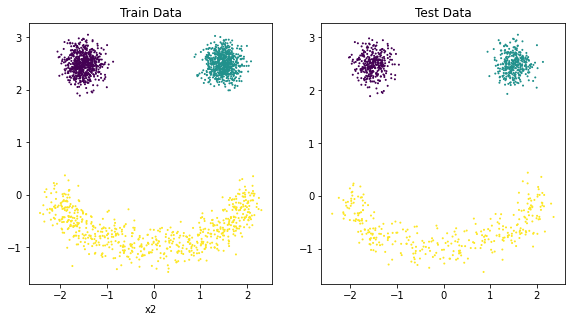

Dataset 2


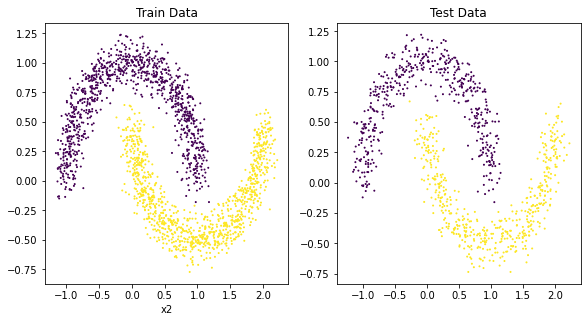

In [35]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial t} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [48]:
class ContiniousNormalazingFlow(nn.Module):
    def __init__(self,
                 input_dim : int = 2,
                 hidden_dim: int = 16, 
                 width: int = 3,
                 ) -> None:

        super().__init__()

        self.input_dim = input_dim
        self.width = width
        self.block_size = width * input_dim

        self.model = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2 * self.block_size + width)
        )

        self.base_dist = MultivariateNormal(
            torch.zeros(input_dim, device=device),
            torch.eye(input_dim, device=device)
        )

    def _get_u_w_b(self,
                   t: torch.tensor,
                   ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        out = self.model(t.unsqueeze(0)).squeeze()

        u = out[: self.block_size].reshape(self.width, 1, self.input_dim)
        w = out[self.block_size : 2 * self.block_size].reshape(
            self.width,
            self.input_dim,
            1
        )
        b = out[-self.width :].reshape(self.width, 1, 1)

        return u, w, b

    def _get_dz_dt(self,
                   t: torch.tensor,
                   z: torch.tensor,
                   ) -> torch.tensor:

        u, w, b = self._get_u_w_b(t)
        z_r = z.unsqueeze(0).repeat(self.width, 1, 1)
        h = torch.tanh(z_r.matmul(w) + b)

        return h.matmul(u).mean(dim=0)

    def _get_dlog_p_dt(self,
                       f: torch.tensor,
                       z: torch.tensor,
                       ) -> torch.tensor:
                       
        raise NotImplementedError()

    @torch.enable_grad()
    def forward(self,
                t: torch.tensor,
                input: Tuple[torch.tensor, torch.tensor],
                ) -> Tuple[torch.tensor, torch.tensor]:

        z, _ = input
        z.requires_grad_(True)

        dz_dt = self._get_dz_dt(t, z)

        dlog_p_dt = self._get_dlog_p_dt(dz_dt, z)

        return dz_dt, dlog_p_dt

    def _flow(self,
              z_1: torch.tensor, 
              t_0: float = 0.0,
              t_1: float = 10.0,
              tolerance: float = 1e-5,
              ) -> Tuple[torch.tensor, torch.tensor]:

        dlog_p_dt_1 = torch.zeros(
            (z_1.shape[0], 1), dtype=torch.float32, device=device
        )
        time_interval = torch.tensor(
            [t_1, t_0], dtype=torch.float32, device=device
        )

        z_t, m_log_det_t = odeint(
            self,
            (z_1, dlog_p_dt_1),
            time_interval,
            atol=tolerance,
            rtol=tolerance,
            method='dopri5',
        )
        
        return z_t[-1], -m_log_det_t[-1]

    def _log_prob(self,
                  batch: torch.tensor,
                  t_0: float = 0.0,
                  t_1: float = 10.0,
                  tolerance: float = 1e-5,
                  ) -> torch.tensor:
        
        batch_size = batch.shape[0]

        z, log_det = self._flow(batch, t_0, t_1, tolerance)
        lop_p_z = self.base_dist.log_prob(z).reshape(batch_size, 1)

        return lop_p_z + log_det

    def _calculate_loss(self,
                        batch: torch.tensor, 
                        t_0: float = 0.0,
                        t_1: float = 10.0,
                        tolerance: float = 1e-5,
                        ) -> nn.NLLLoss:

        return -self._log_prob(batch, t_0, t_1, tolerance).mean()

    @torch.no_grad()
    def get_probabilities(self,
                          dataloader: DataLoader,
                          t_0: float = 0.0,
                          t_1: float = 10.0,
                          tolerance: float = 1e-5,
                          ) -> np.ndarray:
                          
      probabilities = []
      for batch in dataloader:
          batch = batch.to(device)

          p_batch = self._log_prob(batch, t_0, t_1, tolerance).exp()
          probabilities.append(p_batch.cpu().numpy())

      return np.vstack(probabilities)

    @torch.no_grad()
    def get_latent_vectors(self,
                           dataloader: DataLoader,
                           t_0: float = 0.0,
                           t_1: float = 10.0,
                           tolerance: float = 1e-5,
                           ) -> np.ndarray:

        latent_vectors = []
        for batch in dataloader:
            batch = batch.to(device)

            z = self._flow(batch, t_0, t_1, tolerance)[0]
            latent_vectors.append(z.cpu().numpy())

        return np.vstack(latent_vectors)

    @torch.no_grad()
    def _test(self,
              test_dataloader: DataLoader,
              t_0: float = 0.0,
              t_1: float = 10.0,
              tolerance: float = 1e-5,
              ) -> float:

        self.eval()
        sum_loss = 0
        n_elements = 0
        for batch in test_dataloader:
            batch_size = batch.shape[0]
            batch = batch.to(device)

            loss = self._calculate_loss(batch, t_0, t_1, tolerance)
            sum_loss += batch_size * loss
            n_elements += batch_size

        return sum_loss.item() / n_elements

    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            t_0: float = 0.0,
            t_1: float = 10.0,
            tolerance: float = 1e-5,
            epochs: int = 20,
            lr: float = 1e-3,
            ) -> Tuple[List[float], List[float]]:

        train_losses = []
        test_losses = []

        optim = torch.optim.Adam(self.parameters(), lr=lr)

        test_losses.append(self._test(test_dataloader, t_0, t_1, tolerance))

        for epoch in trange(epochs, desc="Training"):
            self.train()
            sum_loss = 0
            n_elements = 0
            for batch in train_dataloader:
                batch_size = batch.shape[0]
                batch = batch.to(device)

                loss = self._calculate_loss(batch, t_0, t_1, tolerance)

                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                sum_loss += batch_size * loss
                n_elements += batch_size

            train_losses.append(sum_loss.item() / n_elements)
            test_losses.append(self._test(test_dataloader, t_0, t_1, tolerance))
          
        return train_losses, test_losses

In [49]:
class CNF(ContiniousNormalazingFlow):
    def _get_dlog_p_dt(self,
                       f: torch.tensor,
                       z: torch.tensor,
                       ) -> torch.tensor:

        batch_size = z.shape[0]
        m_trace = torch.zeros(batch_size, dtype=torch.float32, device=device)
        for i in range(self.input_dim):
            m_trace -= torch.autograd.grad(
                f[:, i].sum(),
                z,
                create_graph=True
            )[0][:, i]

        return m_trace.reshape(batch_size, 1)

In [50]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2)

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    input_dim = train_data.shape[1]
    hidden_dim = 32
    width = 3
    t_0 = 0.0
    t_1 = 10.0
    tolerance = 1e-5
    
    epochs = 100
    batch_size = 128
    lr = 1e-3

    model = CNF(input_dim, hidden_dim, width).to(device)
    
    train_dataloader = DataLoader(
        torch.tensor(train_data, dtype=torch.float32),
        batch_size=batch_size,
        shuffle=True
    )
    test_dataloader = DataLoader(
        torch.tensor(test_data, dtype=torch.float32),
        batch_size=batch_size,
        shuffle=False
    )

    train_losses, test_losses = model.fit(
        train_dataloader, test_dataloader, t_0, t_1, tolerance, epochs, lr
    )

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)
    ]

    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    mesh_xs_dataloader = DataLoader(
        torch.tensor(mesh_xs, dtype=torch.float32),
        batch_size=batch_size,
        shuffle=False
    )
    densities = model.get_probabilities(mesh_xs_dataloader)

    points_dataloader = DataLoader(
        torch.FloatTensor(train_data),
        batch_size=batch_size, 
        shuffle=False
    )
    latents = model.get_latent_vectors(points_dataloader)

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Training:   0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 1.4937


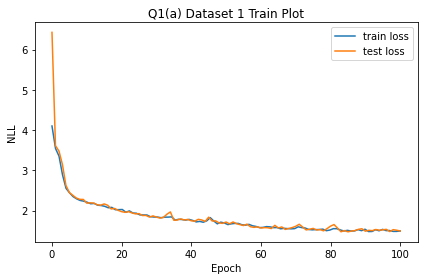

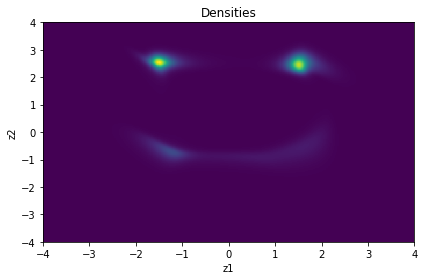

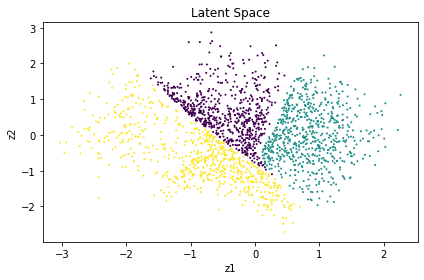

In [51]:
q1_save_results(1, 'a', q1)

Training: 100%|██████████| 100/100 [06:25<00:00,  3.85s/it]


Final Test Loss: 1.2152


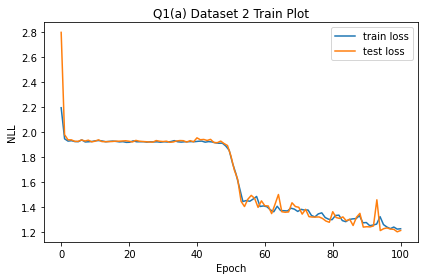

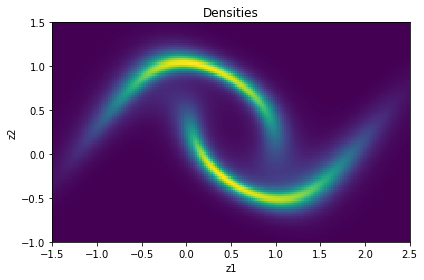

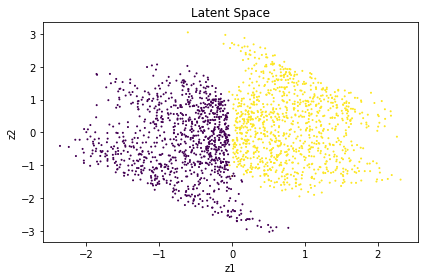

In [ ]:
q1_save_results(2, 'a', q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [45]:
class HCNF(ContiniousNormalazingFlow):
    def _get_dlog_p_dt(self,
                       f: torch.tensor,
                       z: torch.tensor,
                       ) -> torch.tensor:

        v = 2 * torch.randint(0, 2, (self.input_dim, 1)) - 1
        v = v.to(torch.float32).to(device)

        A = torch.autograd.grad(
            f.matmul(v).sum(),
            z,
            create_graph=True
        )[0]

        return -A.matmul(v)

In [52]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets, or
              for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """
    
    input_dim = train_data.shape[1]
    hidden_dim = 32
    width = 3
    t_0 = 0.0
    t_1 = 10.0
    tolerance = 1e-2
    
    epochs = 100
    batch_size = 128
    lr = 1e-3

    model = CNF(input_dim, hidden_dim, width).to(device)
    
    train_dataloader = DataLoader(
        torch.tensor(train_data, dtype=torch.float32),
        batch_size=batch_size,
        shuffle=True
    )
    test_dataloader = DataLoader(
        torch.tensor(test_data, dtype=torch.float32),
        batch_size=batch_size,
        shuffle=False
    )

    train_losses, test_losses = model.fit(
        train_dataloader, test_dataloader, t_0, t_1, tolerance, epochs, lr
    )

    return train_losses, test_losses

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Training:   0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 13.2222


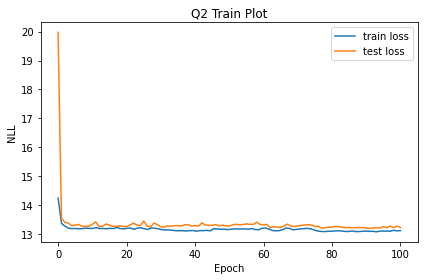

In [47]:
q2_save_results(q2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Final Test Loss: 13.6341


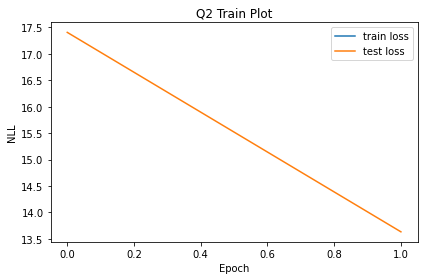

In [27]:
q2_save_results(q2) #обучение одной эпохи со старыми толерансами

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets, or
              for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """
    
    """ YOUR CODE HERE """

### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)